In [8]:
import keras
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import Callback
from keras.utils import plot_model
import time
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
#---------------------加载数据----------------------------
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#------------------------------------------------------
# 数据预处理
X_train = X_train.reshape(-1, 1,28, 28)/255.
X_test = X_test.reshape(-1, 1,28, 28)/255.
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

In [3]:
#-------------------------------------------------------------
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.savefig('acc-loss of cnn.png', dpi=400)
        plt.show()

In [4]:
#-------------------------------------------------------------------------
#建立CNN网络
model = Sequential()

model.add(Convolution2D(32, (3, 3), input_shape=(1,28,28),data_format='channels_first'))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Convolution2D(32, (3, 3),name='conv_1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Convolution2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))
#----------------------------------------------
#优化函数
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

#--------------------------------------------------------
# 编译函数
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#------------------------------------------------------
#创建一个实例history
history = LossHistory()


In [5]:
#--------------------------------------------------------------------------
print('Training ------------')
#训练
model.fit(X_train, y_train,
          validation_split=0.3,epochs=50,verbose=2,
          batch_size=512,
          callbacks=[history])

Training ------------
Train on 42000 samples, validate on 18000 samples
Epoch 1/50
 - 6s - loss: 0.5664 - acc: 0.8266 - val_loss: 0.2181 - val_acc: 0.9314
Epoch 2/50
 - 4s - loss: 0.1464 - acc: 0.9549 - val_loss: 0.1255 - val_acc: 0.9619
Epoch 3/50
 - 4s - loss: 0.1003 - acc: 0.9690 - val_loss: 0.0884 - val_acc: 0.9726
Epoch 4/50
 - 4s - loss: 0.0718 - acc: 0.9780 - val_loss: 0.1160 - val_acc: 0.9624
Epoch 5/50
 - 4s - loss: 0.0791 - acc: 0.9746 - val_loss: 0.0754 - val_acc: 0.9768
Epoch 6/50
 - 4s - loss: 0.0540 - acc: 0.9825 - val_loss: 0.0638 - val_acc: 0.9811
Epoch 7/50
 - 4s - loss: 0.0445 - acc: 0.9855 - val_loss: 0.0599 - val_acc: 0.9821
Epoch 8/50
 - 4s - loss: 0.0375 - acc: 0.9879 - val_loss: 0.0526 - val_acc: 0.9842
Epoch 9/50
 - 4s - loss: 0.0299 - acc: 0.9903 - val_loss: 0.0915 - val_acc: 0.9736
Epoch 10/50
 - 4s - loss: 0.0481 - acc: 0.9843 - val_loss: 0.0507 - val_acc: 0.9856
Epoch 11/50
 - 4s - loss: 0.0236 - acc: 0.9928 - val_loss: 0.0563 - val_acc: 0.9842
Epoch 12/50
 


Testing ------------
10000/10000 [==============================] - 1s 113us/step

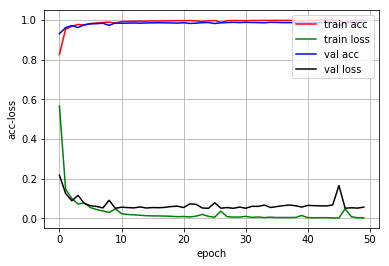

In [6]:
#-----------------------------------------------------
print('\nTesting ------------')
# 测试
loss, accuracy = model.evaluate(X_test, y_test)

#----------------------------------------------------
print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

#---------------------------------------------------------------------------
#绘制acc-loss曲线
history.loss_plot('epoch')
#----------------------
#----------------------------------------------------------------------------


In [9]:
# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\GitHub\Neural-Network-Theory-and-Applications-Homework-SJTU2018\Homework Assignment 3\saved_models\keras_cifar10_trained_model.h5 


In [10]:
#模型可视化

intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[2].output])
intermediate_tensor = intermediate_tensor_function([np.expand_dims(X_train[0],axis=0)])[0]
intermediate_tensor1=np.squeeze(intermediate_tensor)

ValueError: array split does not result in an equal division

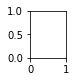

In [11]:
i=1
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=2
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=3
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=4
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=5
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=6
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=7
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=8
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=9
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=10
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=11
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=12
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=13
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=14
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=15
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=16
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=17
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=18
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=19
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=20
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=21
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=22
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=23
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=24
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=25
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=26
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=27
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=28
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=29
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=30
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=31
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=32
plt.subplot(4,8,i)
a=np.split(intermediate_tensor1,32)[i-1]
b=np.squeeze(a)
plt.imshow(b)

In [ ]:
train0=np.squeeze(X_train[0])
train0.shape
plt.imshow(train0)

In [ ]:
#模型可视化
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[4].output])
intermediate_tensor = intermediate_tensor_function([np.expand_dims(X_train[0],axis=0)])[0]

In [ ]:
intermediate_tensor2=np.squeeze(intermediate_tensor)
intermediate_tensor2.shape

In [ ]:
i=1
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=2
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=3
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=4
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=5
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=6
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=7
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=8
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=9
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=10
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=11
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=12
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=13
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=14
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=15
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=16
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=17
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=18
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=19
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=20
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=21
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=22
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=23
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=24
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=25
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=26
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=27
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=28
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=29
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=30
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=31
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=32
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=33
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=34
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=35
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=36
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=37
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=38
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=39
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=40
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=41
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=42
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=43
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=44
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=45
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=46
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=47
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=48
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=49
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=50
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=51
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=52
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=53
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=54
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=55
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=56
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=57
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=58
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=59
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=60
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=61
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=62
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=63
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)
i=64
plt.subplot(8,8,i)
a=np.split(intermediate_tensor2,64)[i-1]
b=np.squeeze(a)
plt.imshow(b)

In [ ]:
from keras import layers
print(len(model.layers))
layer_count=len(model.layers)
for i,layer in enumerate(model.layers):
    print('layer:',i+1)
    print(len(layer.get_weights()))

In [ ]:
firstconv=model.layers[0].get_weights()
firstconv[0].shape


In [ ]:
firstconv[1]

In [ ]:
kernel1=np.squeeze(firstconv[0])
kernel1.shape
kernel1[0]

In [ ]:
kernel1=np.transpose(kernel1,(1,0,2))
kernel1.shape


In [ ]:
i=1
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=2
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=3
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=4
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=5
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=6
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=7
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=8
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=9
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=10
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=11
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=12
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=13
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=14
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=15
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=16
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=17
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=18
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=19
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=20
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=21
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=22
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=23
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=24
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])
i=25
plt.subplot(5,5,i)
plt.imshow(kernel1[i-1])



In [ ]:
secondconv=model.layers[3].get_weights()
secondconv[0].shape